# **New York City Taxi Fare Prediction** #

# **I. Pendahuluan**

Dataset ini berisi data perjalanan taxi di New York City, dengan beberapa informasi penting seperti pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, dan tentu saja fare_amount yang jadi target dari prediksi kita.

Setiap baris merepresentasikan satu perjalanan taxi, dan data ini bisa digunakan untuk mempelajari pola-pola perjalanan, pricing behavior, dan bahkan aspek geografis dari kota NYC. Proyek ini fokus untuk membangun model machine learning yang bisa memprediksi tarif taxi hanya berdasarkan informasi yang tersedia sebelum perjalanan terjadi.

Tujuan: Regresi

Memprediksi fare amount (jumlah tarif) dari suatu perjalanan taxi berdasarkan fitur-fitur seperti lokasi pickup dan dropoff, waktu, dan jumlah penumpang.

# **II. Paparan data**


## *II.a Library*

In [2]:
import os

# Pindah ke folder D:
os.chdir("H:/big_data")

# Lihat isi folder untuk cek
print(os.listdir())


['KELOMPOK 7-TAXIII.ipynb', 'KELOMPOK 7-TAXIIiiiiiiiiI.ipynb', 'spark-temp', 'Taxi-Fare_Kelompok-7-main', 'test.csv', 'train.csv']


In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import radians, cos, sin, asin, sqrt, atan2
from pyspark.sql.functions import col, mean as _mean, stddev as _std
from pyspark.sql.functions import col, when, count
from pyspark.sql.functions import col, year, month, dayofmonth, hour, minute, second, dayofweek, to_timestamp
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## *II.b Dataset*

In [4]:
print(pyspark.__version__)

3.5.5


In [5]:
spark = SparkSession.builder \
    .appName("TaxiProject") \
    .master("local[12]") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "12g") \
    .config("spark.sql.shuffle.partitions", "12") \
    .getOrCreate()


df = spark.read.csv("H:/big_data/train.csv", header=True, inferSchema=True)

df.show(5)

df.printSchema()


+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|2009-06-15 17:26:21|        4.5|2009-06-16 00:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|
|2010-01-05 16:52:16|       16.9|2010-01-05 23:52:16|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|
|2011-08-18 00:35:00|        5.7|2011-08-18 07:35:00|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|
|2012-04-21 04:30:42|        7.7|2012-04-21 11:30:42|       -73.98713|      40.733143|       -73.991567|       40.758092|              1|
|2010-03-09 07:51:00|        5.3|2

## *II.c Data Cleaning*

Drop Duplicates

In [6]:
df = df.dropDuplicates()

In [7]:
df.select("fare_amount").describe().show()

+-------+------------------+
|summary|       fare_amount|
+-------+------------------+
|  count|          55422206|
|   mean|11.345146344023467|
| stddev|20.711096366070453|
|    min|            -300.0|
|    max|          93963.36|
+-------+------------------+



In [8]:
df.select("passenger_count").describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          55422206|
|   mean| 1.685387911119958|
| stddev|1.3273829710373264|
|    min|                 0|
|    max|               208|
+-------+------------------+



In [9]:
# Check for missing values
missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|key|fare_amount|pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|  0|          0|              0|               0|              0|              376|             376|              0|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+



In [10]:
# Remove rows with missing values
df = df.dropna()

# Remove outliers
df = df.filter(
    (df.passenger_count > 0) & (df.passenger_count <= 6) & (df.fare_amount > 0)
)

Convert to Distance

In [11]:
# Radius bumi dalam kilometer
R = 6371.0

# Hitung distance menggunakan Haversine formula
df = df.withColumn("pickup_lat_rad", radians(col("pickup_latitude"))) \
       .withColumn("pickup_lon_rad", radians(col("pickup_longitude"))) \
       .withColumn("dropoff_lat_rad", radians(col("dropoff_latitude"))) \
       .withColumn("dropoff_lon_rad", radians(col("dropoff_longitude"))) \
       .withColumn("dlat", col("dropoff_lat_rad") - col("pickup_lat_rad")) \
       .withColumn("dlon", col("dropoff_lon_rad") - col("pickup_lon_rad")) \
       .withColumn("a", sin(col("dlat")/2)**2 +
                         cos(col("pickup_lat_rad")) * cos(col("dropoff_lat_rad")) *
                         sin(col("dlon")/2)**2) \
       .withColumn("c", 2 * atan2(sqrt(col("a")), sqrt(1 - col("a")))) \
       .withColumn("distance", R * col("c"))

# Optional: Hapus kolom bantu biar DataFrame tetap bersih
df = df.drop("pickup_lat_rad", "pickup_lon_rad", "dropoff_lat_rad", "dropoff_lon_rad", "dlat", "dlon", "a", "c")



Pada bagian ini, kita menghitung jarak tempuh (dalam kilometer) antara titik penjemputan dan titik pengantaran menggunakan rumus Haversine. Rumus ini memperhitungkan kelengkungan bumi sehingga hasil jaraknya lebih akurat.

Langkah-langkahnya:
- Mengonversi koordinat (latitude & longitude) dari derajat ke radian.
- Menghitung selisih koordinat antara pickup dan dropoff.
- Menerapkan rumus Haversine untuk mendapatkan jarak.
- Menyimpan hasilnya ke dalam kolom baru bernama distance.
- Terakhir, kolom-kolom bantu dihapus agar data tetap rapi.

Hasil akhirnya: setiap baris data sekarang punya nilai jarak (dalam km) antara lokasi penjemputan dan tujuan.

In [12]:
df.select("distance").describe().show()

+-------+------------------+
|summary|          distance|
+-------+------------------+
|  count|          55222860|
|   mean|19.688749700083076|
| stddev| 369.1452942673537|
|    min|               0.0|
|    max|19688.800562469834|
+-------+------------------+



In [13]:
# Filter distance yang tidak masuk akal (opsional)
df = df.filter((df.distance > 0.2) & (df.distance < 100))

In [14]:
# Ubah kolom 'key' ke tipe timestamp
df = df.withColumn("key", to_timestamp("key"))

# Ekstrak bagian waktu
df = df.withColumn("year", year(col("key"))) \
       .withColumn("month", month(col("key"))) \
       .withColumn("day", dayofmonth(col("key"))) \
       .withColumn("hour", hour(col("key"))) \
       .withColumn("minute", minute(col("key"))) \
       .withColumn("second", second(col("key"))) \
       .withColumn("day_of_week", dayofweek(col("key")))  # Note: Minggu = 1, Senin = 2, dst


Bagian ini melakukan pengolahan terhadap kolom key yang berisi data waktu.

Langkah-langkahnya:
Ubah tipe data kolom key menjadi format waktu (timestamp) agar bisa diproses lebih lanjut.
Ekstrak informasi waktu dari kolom tersebut, seperti:
- Tahun (year)
- Bulan (month)
- Tanggal (day)
- Jam (hour)
- Menit (minute)
- Detik (second)
- Hari dalam minggu (day_of_week), dengan format: Minggu = 1, Senin = 2, dan seterusnya.

Tujuannya adalah untuk menambahkan fitur-fitur waktu yang bisa berguna dalam proses analisis atau pemodelan, misalnya untuk melihat pola berdasarkan waktu tertentu.

In [15]:
df = df.withColumn("rush_hour", when((df.hour >= 7) & (df.hour <= 9), 1)
                                 .when((df.hour >= 16) & (df.hour <= 19), 1)
                                 .otherwise(0))

In [16]:
df = df.withColumn("time_of_day", when((df.hour >= 5) & (df.hour < 12), "morning")
                                 .when((df.hour >= 12) & (df.hour < 17), "afternoon")
                                 .when((df.hour >= 17) & (df.hour < 21), "evening")
                                 .otherwise("night"))



# Ubah kategori string jadi angka
indexer = StringIndexer(inputCol="time_of_day", outputCol="time_of_day_index")
df = indexer.fit(df).transform(df)

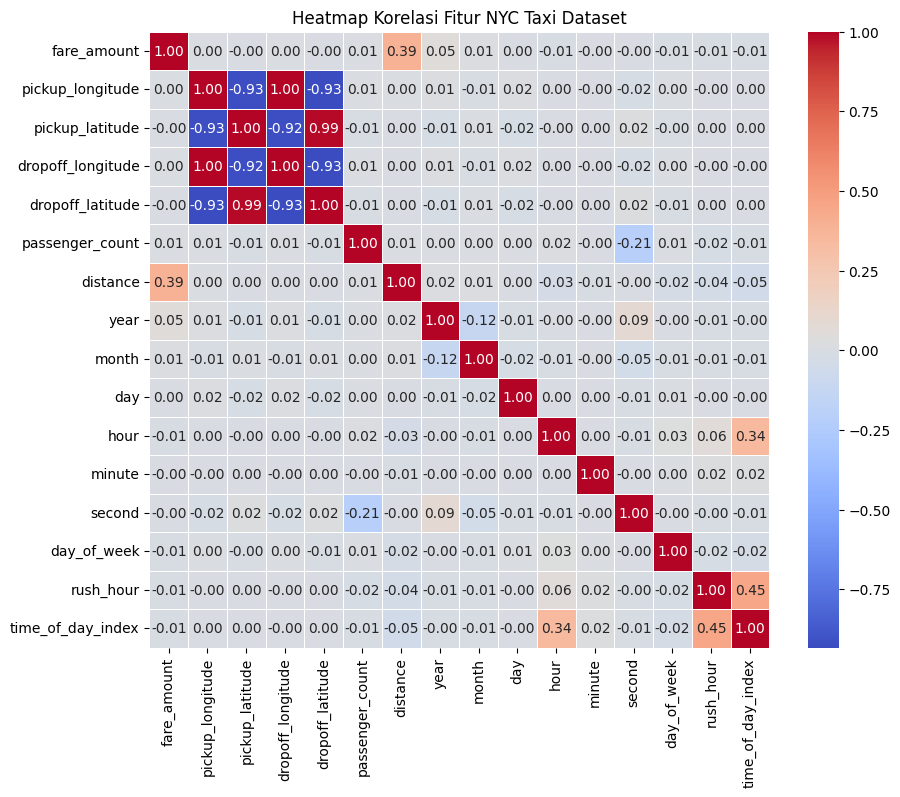

In [17]:
# Pilih kolom numerik
numeric_cols = ['fare_amount', 'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'distance', 'year', 'month', 'day', 'hour', 'minute', 'second', 'day_of_week','rush_hour', 'time_of_day_index']

# Gabungkan jadi satu kolom vektor
vec_assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = vec_assembler.transform(df).select("features")

# Hitung korelasi
correlation_matrix = Correlation.corr(df_vector, "features", "pearson").head()[0]
corr_array = correlation_matrix.toArray()

# Ubah ke pandas dataframe
corr_df = pd.DataFrame(corr_array, index=numeric_cols, columns=numeric_cols)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Fitur NYC Taxi Dataset")
plt.show()


In [18]:
df = df.drop("key", "pickup_datetime")

In [19]:
df.show(5)

+-----------+----------------+---------------+-----------------+----------------+---------------+------------------+----+-----+---+----+------+------+-----------+---------+-----------+-----------------+
|fare_amount|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|          distance|year|month|day|hour|minute|second|day_of_week|rush_hour|time_of_day|time_of_day_index|
+-----------+----------------+---------------+-----------------+----------------+---------------+------------------+----+-----+---+----+------+------+-----------+---------+-----------+-----------------+
|        4.5|      -73.844311|      40.721319|        -73.84161|       40.712278|              1| 1.030763935049508|2009|    6| 15|  17|    26|    21|          2|        1|    evening|              3.0|
|       16.9|      -74.016048|      40.711303|       -73.979268|       40.782004|              1| 8.450133595805992|2010|    1|  5|  16|    52|    16|          3|        1|  afternoon|    

## *II.d Visualization & Exploratory Data Analysis (EDA)*

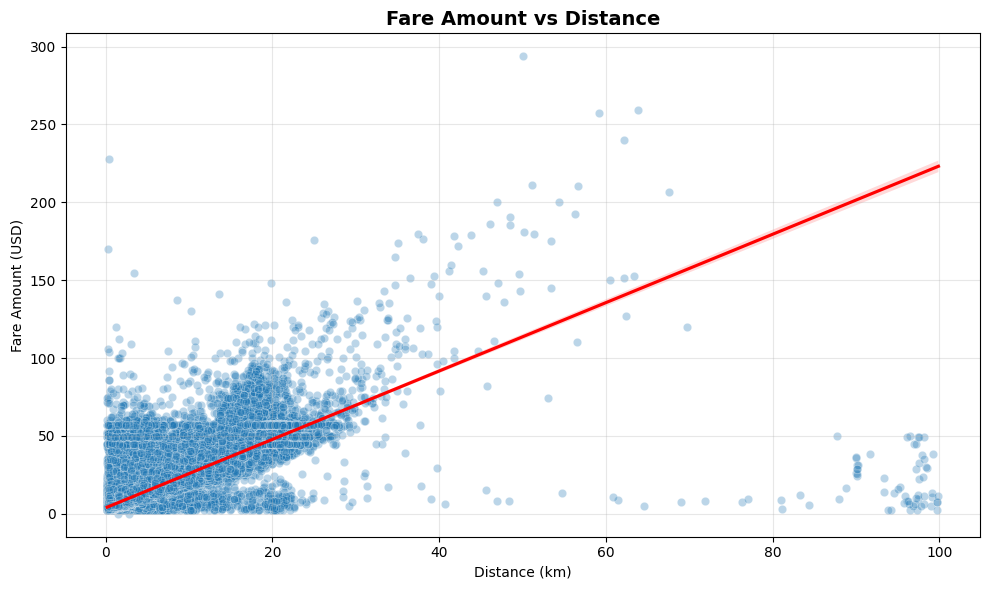

In [20]:
sample = df.select("distance", "fare_amount").sample(False, 0.01).toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample, x="distance", y="fare_amount", alpha=0.3)
sns.regplot(data=sample, x="distance", y="fare_amount", scatter=False, color="red")
plt.title("Fare Amount vs Distance", fontsize=14, weight='bold')
plt.xlabel("Distance (km)")
plt.ylabel("Fare Amount (USD)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Menampilkan grafik hubungan antara jarak (distance) dan tarif (fare_amount). Diambil sampel 1% data untuk membuat scatter plot, lalu ditambahkan garis tren regresi. Hasil visualisasi menunjukkan bahwa tarif cenderung meningkat seiring bertambahnya jarak.

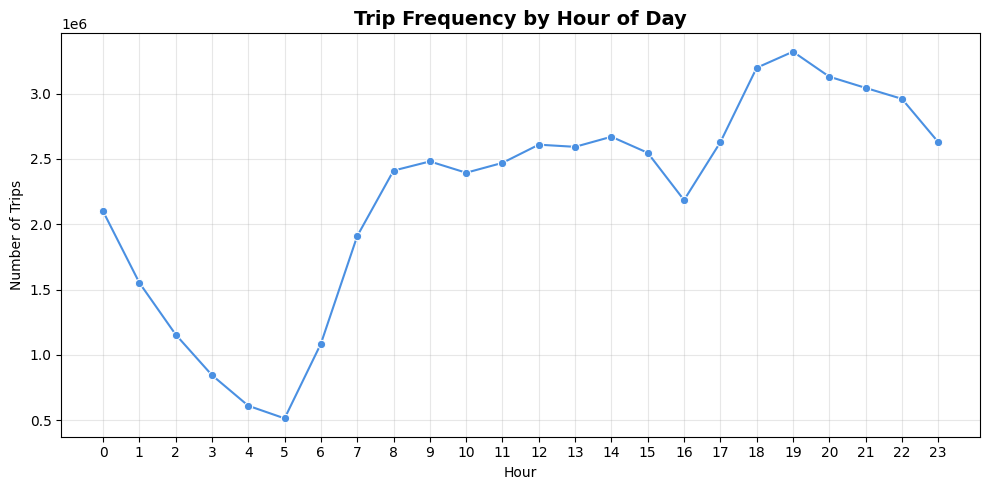

In [21]:
hour_df = df.groupBy("hour").count().orderBy("hour").toPandas()

plt.figure(figsize=(10, 5))
sns.lineplot(x="hour", y="count", data=hour_df, marker='o', color="#4A90E2")
plt.title("Trip Frequency by Hour of Day", fontsize=14, weight='bold')
plt.xlabel("Hour")
plt.ylabel("Number of Trips")
plt.xticks(range(0, 24))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Membuat grafik garis untuk menunjukkan jumlah perjalanan taksi berdasarkan jam dalam sehari. Data dikelompokkan berdasarkan kolom hour, lalu dihitung jumlah perjalanannya dan ditampilkan dalam bentuk grafik menggunakan seaborn. Hasil visualisasi membantu melihat jam-jam sibuk di mana taksi paling banyak digunakan.

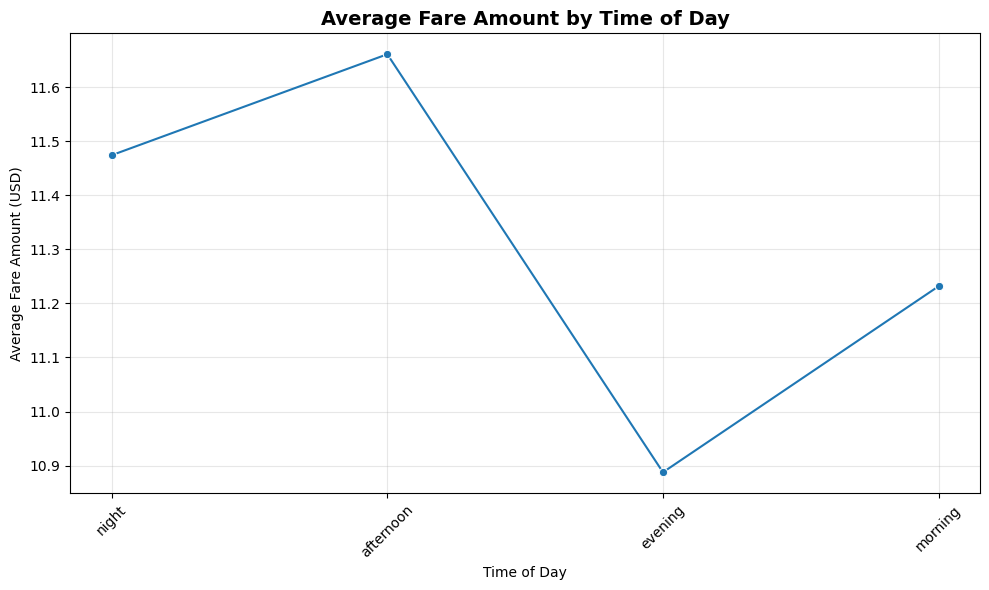

In [22]:
time_fare = df.groupBy("time_of_day").agg({"fare_amount": "mean"}).toPandas()
plt.figure(figsize=(10, 6))
sns.lineplot(data=time_fare, x="time_of_day", y="avg(fare_amount)", marker='o')
plt.title("Average Fare Amount by Time of Day", fontsize=14, weight='bold')
plt.xlabel("Time of Day")
plt.ylabel("Average Fare Amount (USD)")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Visualisasi ini menunjukkan rata-rata tarif taksi berdasarkan waktu dalam sehari. Data dikelompokkan berdasarkan kategori time_of_day, lalu dihitung rata-rata fare_amount untuk masing-masing kelompok. Grafik ini membantu memahami pola perubahan tarif sepanjang hari.

C:\Users\murah\AppData\Local\Temp\ipykernel_15964\1921763799.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rush_hour_count, x="rush_hour", y="count(fare_amount)", palette="pastel")


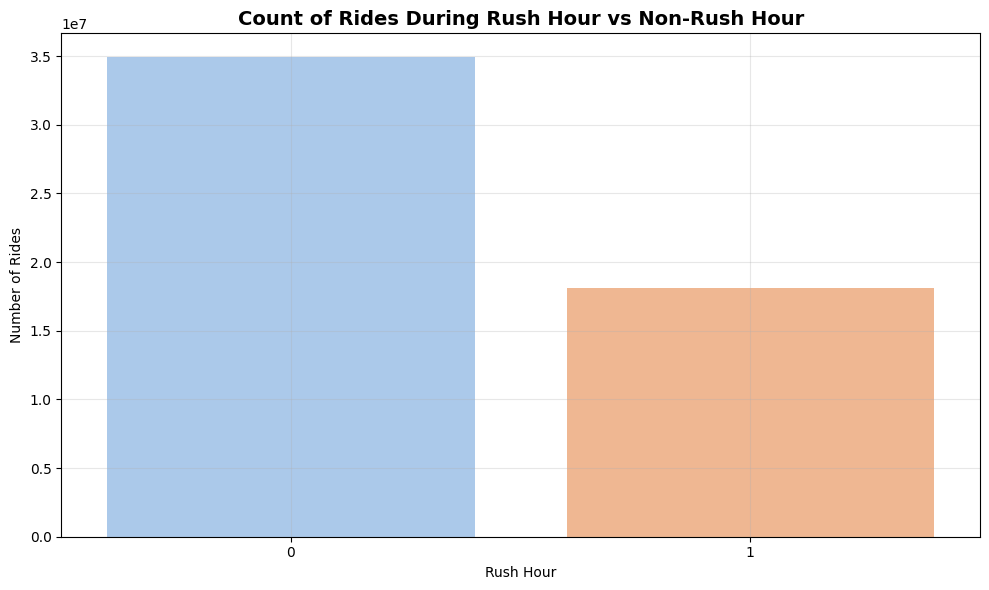

In [23]:
rush_hour_count = df.groupBy("rush_hour").agg({"fare_amount": "count"}).toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=rush_hour_count, x="rush_hour", y="count(fare_amount)", palette="pastel")
plt.title("Count of Rides During Rush Hour vs Non-Rush Hour", fontsize=14, weight='bold')
plt.xlabel("Rush Hour")
plt.ylabel("Number of Rides")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Grafik ini membandingkan jumlah perjalanan taksi antara waktu rush hour dan non-rush hour. Data dikelompokkan berdasarkan kolom rush_hour, lalu dihitung jumlah perjalanan (fare_amount). Visualisasi ini memberikan gambaran intensitas perjalanan selama jam sibuk.

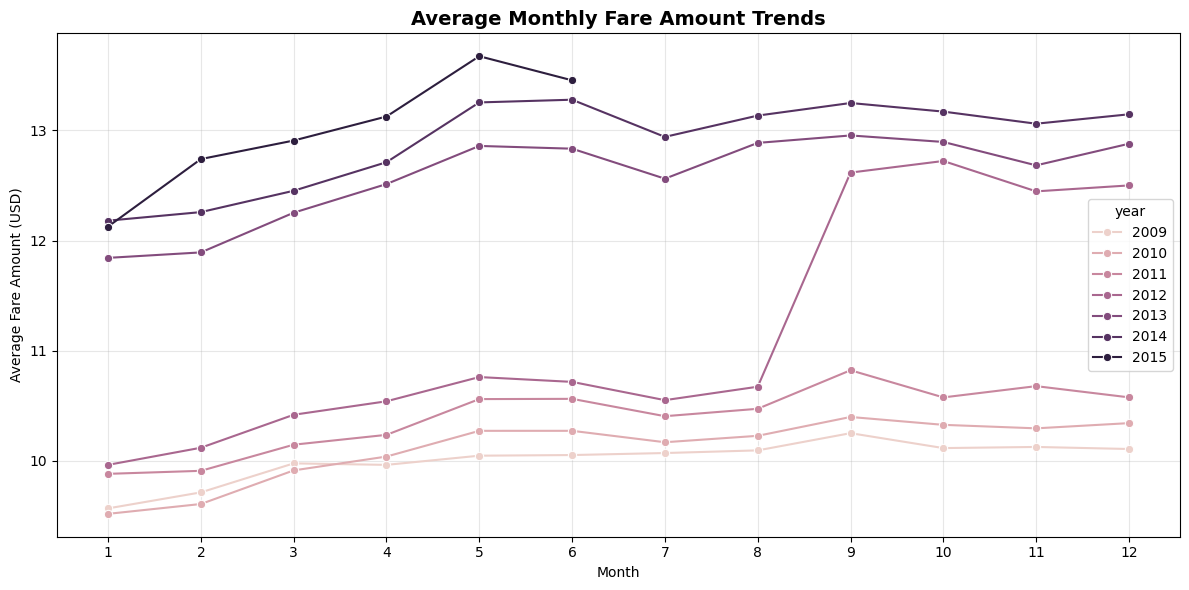

In [24]:
monthly_fare = df.groupBy("year", "month").agg({"fare_amount": "mean"}).toPandas()
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_fare, x="month", y="avg(fare_amount)", hue="year", marker='o')
plt.title("Average Monthly Fare Amount Trends", fontsize=14, weight='bold')
plt.xlabel("Month")
plt.ylabel("Average Fare Amount (USD)")
plt.xticks(range(1, 13))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Grafik ini menampilkan tren rata-rata tarif taksi bulanan untuk setiap tahun. Data dikelompokkan berdasarkan year dan month, kemudian dihitung rata-rata fare_amount. Visualisasi ini membantu melihat fluktuasi tarif taksi dari bulan ke bulan dan membandingkannya antar tahun.

C:\Users\murah\AppData\Local\Temp\ipykernel_15964\580856553.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=passenger_fare, x="passenger_count", y="avg(fare_amount)", palette="Set2")


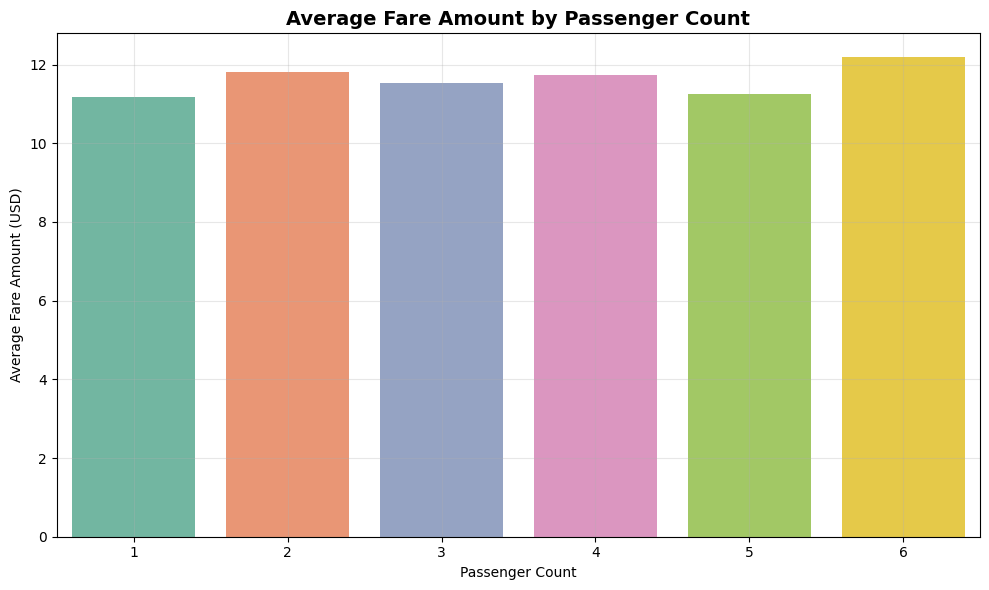

In [25]:
passenger_fare = df.groupBy("passenger_count").agg({"fare_amount": "mean"}).toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=passenger_fare, x="passenger_count", y="avg(fare_amount)", palette="Set2")
plt.title("Average Fare Amount by Passenger Count", fontsize=14, weight='bold')
plt.xlabel("Passenger Count")
plt.ylabel("Average Fare Amount (USD)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Visualisasi ini menunjukkan rata-rata tarif taksi berdasarkan jumlah penumpang. Data dikelompokkan menurut passenger_count, lalu dihitung rata-rata fare_amount untuk masing-masing kelompok. Grafik ini membantu melihat apakah jumlah penumpang berpengaruh terhadap tarif perjalanan.

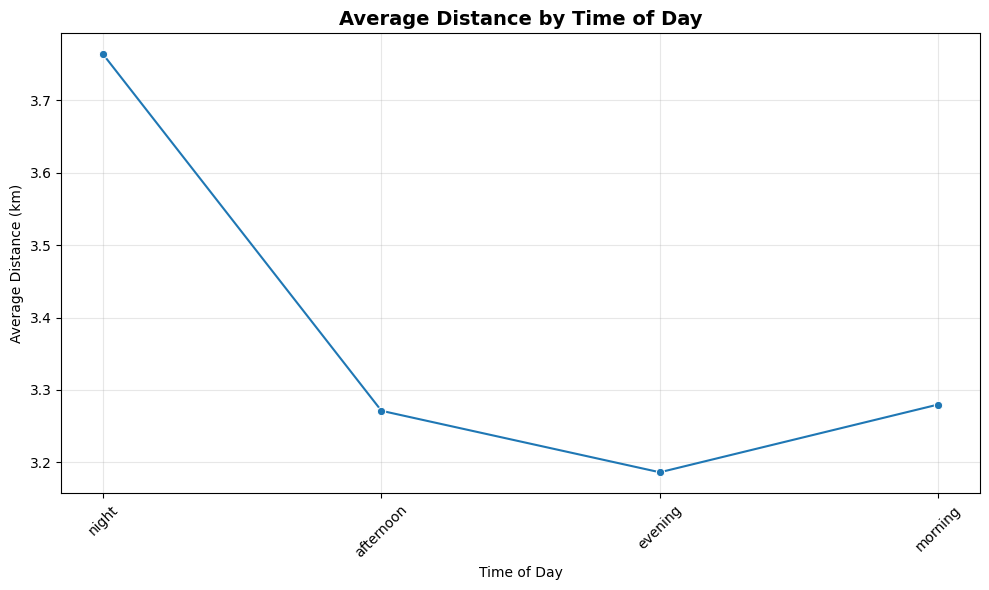

In [26]:
distance_time = df.groupBy("time_of_day").agg({"distance": "mean"}).toPandas()
plt.figure(figsize=(10, 6))
sns.lineplot(data=distance_time, x="time_of_day", y="avg(distance)", marker='o')
plt.title("Average Distance by Time of Day", fontsize=14, weight='bold')
plt.xlabel("Time of Day")
plt.ylabel("Average Distance (km)")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Grafik ini menunjukkan rata-rata jarak tempuh taksi berdasarkan waktu dalam sehari. Data dikelompokkan menurut time_of_day, lalu dihitung rata-rata distance untuk tiap kelompok. Visualisasi ini memberikan gambaran kapan perjalanan taksi cenderung lebih jauh dalam satu hari.

C:\Users\murah\AppData\Local\Temp\ipykernel_15964\2663850631.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=day_count, x="day_of_week", y="count(fare_amount)", palette="pastel")


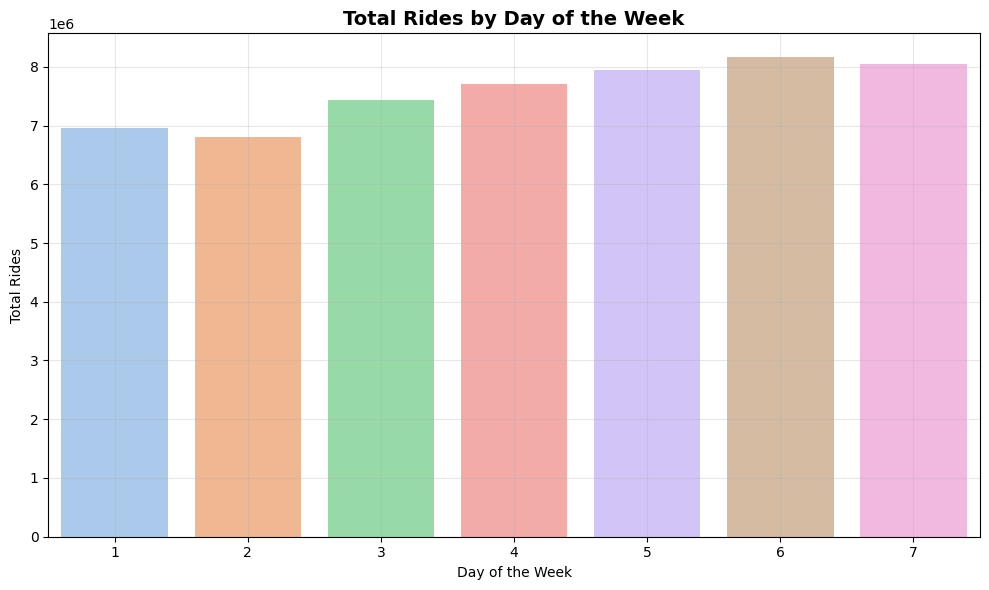

In [27]:
day_count = df.groupBy("day_of_week").agg({"fare_amount": "count"}).toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=day_count, x="day_of_week", y="count(fare_amount)", palette="pastel")
plt.title("Total Rides by Day of the Week", fontsize=14, weight='bold')
plt.xlabel("Day of the Week")
plt.ylabel("Total Rides")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Grafik ini memperlihatkan jumlah total perjalanan taksi berdasarkan hari dalam seminggu. Data dikelompokkan berdasarkan day_of_week, kemudian dihitung jumlah fare_amount sebagai representasi jumlah perjalanan. Visualisasi ini membantu mengidentifikasi hari-hari dengan volume perjalanan tertinggi.

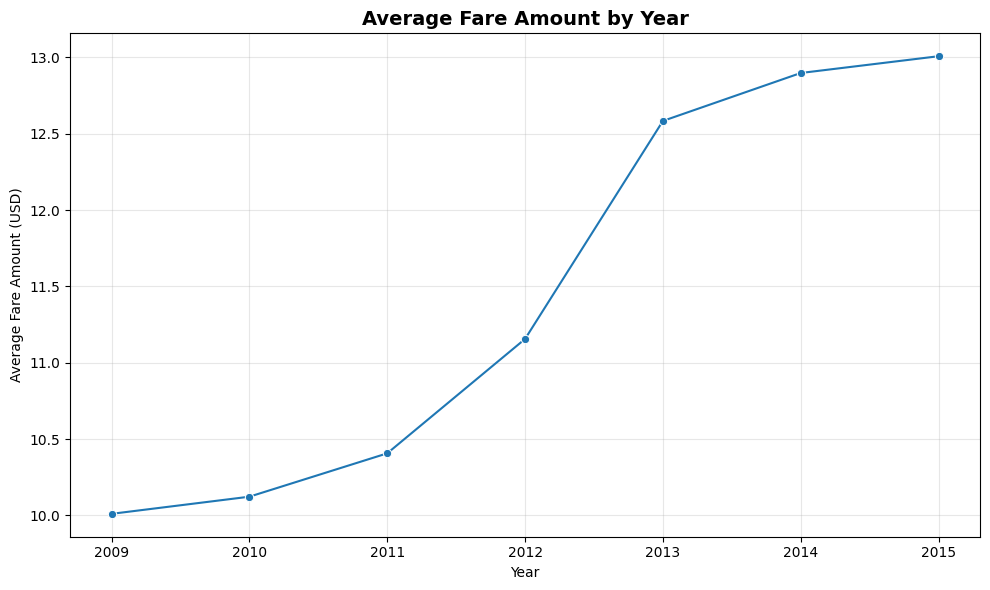

In [28]:
yearly_fare = df.groupBy("year").agg({"fare_amount": "mean"}).toPandas()
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_fare, x="year", y="avg(fare_amount)", marker='o')
plt.title("Average Fare Amount by Year", fontsize=14, weight='bold')
plt.xlabel("Year")
plt.ylabel("Average Fare Amount (USD)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Grafik ini menampilkan rata-rata tarif taksi per tahun. Data dikelompokkan berdasarkan year, lalu dihitung rata-rata fare_amount. Visualisasi ini membantu melihat tren tarif taksi dari tahun ke tahun.

C:\Users\murah\AppData\Local\Temp\ipykernel_15964\2074084961.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=day_distance, x="day_of_week", y="sum(distance)", palette="Blues")


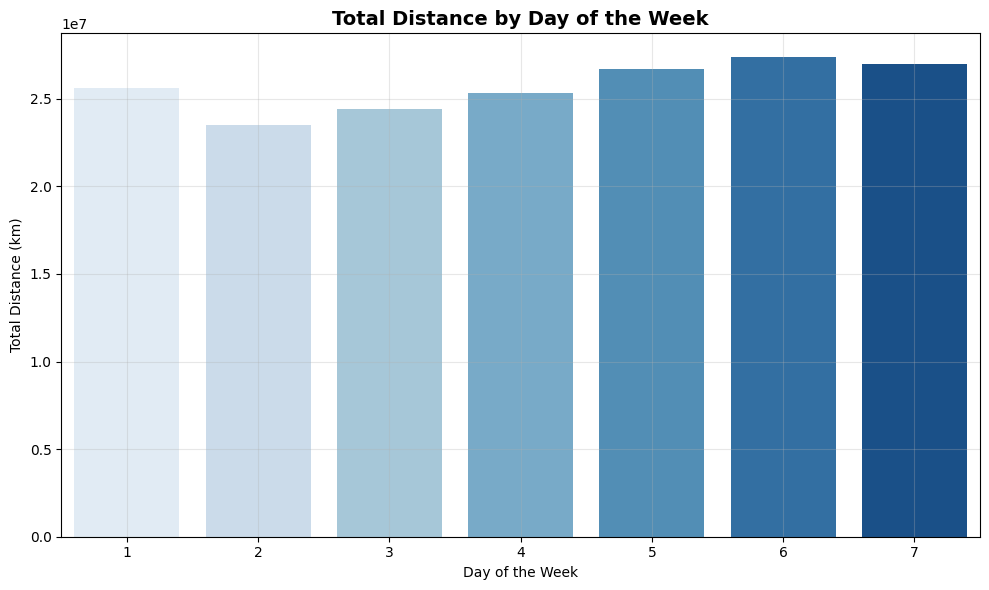

In [29]:
day_distance = df.groupBy("day_of_week").agg({"distance": "sum"}).toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=day_distance, x="day_of_week", y="sum(distance)", palette="Blues")
plt.title("Total Distance by Day of the Week", fontsize=14, weight='bold')
plt.xlabel("Day of the Week")
plt.ylabel("Total Distance (km)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Grafik ini menunjukkan total jarak tempuh perjalanan taksi berdasarkan hari dalam seminggu. Data dikelompokkan menurut day_of_week, lalu dijumlahkan nilai distance untuk setiap hari. Visualisasi ini memberikan gambaran tentang hari-hari dengan aktivitas perjalanan tertinggi secara total jarak.

## *II.e Data Pre-processing*

Tidak memerlukan normalisasi

In [21]:
feature_cols = [
    'passenger_count',
    'distance',
    'year',
    'month',
    'day',
    'hour',
    'minute',
    'day_of_week',
    'rush_hour',
    'time_of_day_index'  # hasil StringIndexer
]


# Gabungkan fitur ke dalam kolom "features", target tetap "fare_amount"
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_model = assembler.transform(df).select("features", "fare_amount")


## *II.f Data Training dan Testing*


In [22]:
# Split train dan test
train_data, test_data = df_model.randomSplit([0.8, 0.2], seed=20)

# Tampilkan X_train dan y_train
print("Isi x_train:")
train_data.select("features").show(5, truncate=False)

print("\nIsi y_train:")
train_data.select("fare_amount").show(5)

# Tampilkan X_test dan y_test
print("\nIsi x_test:")
test_data.select("features").show(5, truncate=False)

print("\nIsi y_test:")
test_data.select("fare_amount").show(5)


Isi x_train:
+---------------------------------------------------------------+
|features                                                       |
+---------------------------------------------------------------+
|[1.0,0.20000781629821182,2015.0,3.0,18.0,8.0,3.0,4.0,1.0,1.0]  |
|[1.0,0.20001450863273249,2014.0,4.0,25.0,23.0,41.0,6.0,0.0,0.0]|
|[1.0,0.20003053124043782,2011.0,2.0,7.0,19.0,56.0,2.0,1.0,3.0] |
|[1.0,0.20004362219430638,2014.0,5.0,22.0,19.0,17.0,5.0,1.0,3.0]|
|[1.0,0.20005184076477275,2012.0,1.0,24.0,18.0,46.0,3.0,1.0,3.0]|
+---------------------------------------------------------------+
only showing top 5 rows


Isi y_train:
+-----------+
|fare_amount|
+-----------+
|        3.5|
|        2.5|
|        3.3|
|        5.0|
|        2.9|
+-----------+
only showing top 5 rows


Isi x_test:
+---------------------------------------------------------------+
|features                                                       |
+---------------------------------------------------------

# **III. Metode: Decision Tree & Random Forest Regressor**


## *III.a Modelling Decision Tree Regressor*

In [23]:
# Inisialisasi dan latih model Decision Tree
dt = DecisionTreeRegressor(featuresCol="features", labelCol="fare_amount")
dt_model = dt.fit(train_data)

# Prediksi terhadap data test
dt_predictions = dt_model.transform(test_data)

# Tampilkan beberapa hasil prediksi vs nilai asli
dt_predictions.select("prediction", "fare_amount").show(10)


+----------------+-----------+
|      prediction|fare_amount|
+----------------+-----------+
|5.00232727212732|       10.0|
|5.00232727212732|        3.5|
|5.00232727212732|       11.5|
|5.00232727212732|        4.5|
|5.00232727212732|       14.5|
|5.00232727212732|       13.3|
|5.00232727212732|       12.1|
|5.00232727212732|        5.3|
|5.00232727212732|        7.3|
|5.00232727212732|        2.5|
+----------------+-----------+
only showing top 10 rows



Model Decision Tree Regressor diinisialisasi untuk memprediksi nilai fare_amount berdasarkan fitur yang telah diproses sebelumnya (features). Model kemudian dilatih menggunakan data train_data, dan selanjutnya digunakan untuk melakukan prediksi pada test_data. Hasil prediksi dibandingkan dengan nilai aktual (fare_amount) dan ditampilkan 10 baris pertama untuk melihat kinerja awal model.

## *III.b Modelling Random Forest Regressor*

In [24]:
# Siapkan model Random Forest
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="fare_amount",
    numTrees=100,        # jumlah pohon, bisa dikurangi kalau training lambat
    maxDepth=10,         # kedalaman maksimum tiap pohon
    seed=42
)

# Latih model dengan data training
rf_model = rf.fit(train_data)

# Prediksi terhadap data test
rf_predictions = rf_model.transform(test_data)

# Tampilkan beberapa hasil prediksi vs nilai asli
rf_predictions.select("prediction", "fare_amount").show(10)


+------------------+-----------+
|        prediction|fare_amount|
+------------------+-----------+
| 5.913762983087522|       10.0|
| 6.076274975599691|        3.5|
| 5.869443317928223|       11.5|
|5.8206603273700015|        4.5|
|  6.38643937923777|       14.5|
| 5.394287754610928|       13.3|
|5.4007185036696725|       12.1|
|  5.25378344411089|        5.3|
| 5.473953595594789|        7.3|
| 5.360013492217601|        2.5|
+------------------+-----------+
only showing top 10 rows



Sama seperti decision tree namun menggunakan algoritma Random Forest Regressor, yaitu ensemble dari banyak Decision Tree untuk meningkatkan akurasi. Model dilatih dengan 100 pohon maksimal kedalaman 10. Setelah pelatihan, prediksi dilakukan pada data uji dan hasilnya juga ditampilkan.

# **IV. Evaluation**

## *IV.a Evaluasi Decision Tree*

In [25]:
# Evaluasi model dengan RMSE
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rmse_dt = evaluator.evaluate(dt_predictions)
print(f"RMSE Decision Tree: {rmse_dt}")

RMSE Decision Tree: 4.241808661844219


Menggunakan Root Mean Squared Error (RMSE) sebagai metrik evaluasi model Decision Tree. RMSE mengukur seberapa besar rata-rata kesalahan prediksi model dibandingkan nilai sebenarnya, semakin kecil nilainya, semakin baik.

In [26]:
# Inisialisasi evaluator R²
r2_evaluator = RegressionEvaluator(
    labelCol="fare_amount",
    predictionCol="prediction",
    metricName="r2"
)

# Hitung R²
r2_dt = r2_evaluator.evaluate(dt_predictions)
print(f"R² Decision Tree: {r2_dt}")


R² Decision Tree: 0.7988459676586394


Evaluasi model Decision Tree menggunakan metrik R² (koefisien determinasi). Nilai R² mengukur seberapa baik model menjelaskan variasi dalam data; mendekati 1 berarti model sangat baik.

## *IV.b Evaluasi Random Forest Regressor*

In [27]:
# Evaluasi model dengan RMSE
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rmse_rf = evaluator.evaluate(rf_predictions)
print(f"RMSE Random Forest: {rmse_rf}")

RMSE Random Forest: 4.198645749146278


Pada bagian ini menghitung RMSE untuk model Random Forest. Ini digunakan untuk membandingkan performa antar model.

In [28]:
# Inisialisasi evaluator untuk R²
r2_evaluator = RegressionEvaluator(
    labelCol="fare_amount",
    predictionCol="prediction",
    metricName="r2"
)

# Hitung R² dari model Random Forest
r2_rf = r2_evaluator.evaluate(rf_predictions)
print(f"R² Random Forest: {r2_rf}")


R² Random Forest: 0.8029188622080674


Pada bagian ini digunakan untuk mengevaluasi R² dari model Random Forest. Hal ini penting untuk melihat model mana yang lebih baik: Decision Tree atau Random Forest.

Model Random Forest memberikan performa terbaik dibanding model Decision Tree.

# **V. Tuning Hyperparameter**

## *V.a Decision Tree*

In [29]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Decision Tree model
dt = DecisionTreeRegressor(labelCol="fare_amount", featuresCol="features")

# Hyperparameter grid
paramGrid_dt = (ParamGridBuilder()
                .addGrid(dt.maxDepth, [3, 5, 10])
                .addGrid(dt.maxBins, [32, 40])
                .build())

# Evaluator
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")

# CrossValidator
cv_dt = CrossValidator(estimator=dt,
                       estimatorParamMaps=paramGrid_dt,
                       evaluator=evaluator,
                       numFolds=3)

# Fit model
cv_model_dt = cv_dt.fit(train_data)

# Evaluate
predictions_dt = cv_model_dt.transform(test_data)
rmse_dt = evaluator.evaluate(predictions_dt)
print("Decision Tree RMSE:", rmse_dt)

Decision Tree RMSE: 4.127500810183967


Melakukan hyperparameter tuning pada model Decision Tree menggunakan Grid Search dan Cross Validation (3-fold). Parameter yang dicoba adalah maxDepth dan maxBins. Tujuannya untuk menemukan kombinasi parameter terbaik yang menghasilkan error terkecil.

## *V.b Random Forest*

In [30]:
from pyspark.ml.regression import RandomForestRegressor

# Random Forest model
rf = RandomForestRegressor(labelCol="fare_amount", featuresCol="features")

# Hyperparameter grid
paramGrid_rf = (ParamGridBuilder()
                .addGrid(rf.numTrees, [20, 50])
                .addGrid(rf.maxDepth, [5, 10])
                .addGrid(rf.maxBins, [32, 64])
                .build())

# CrossValidator
cv_rf = CrossValidator(estimator=rf,
                       estimatorParamMaps=paramGrid_rf,
                       evaluator=evaluator,
                       numFolds=3)

# Fit model
cv_model_rf = cv_rf.fit(train_data)

# Evaluate
predictions_rf = cv_model_rf.transform(test_data)
rmse_rf = evaluator.evaluate(predictions_rf)
print("Random Forest RMSE:", rmse_rf)

Random Forest RMSE: 3.9898427590755974


Proses tuning model Random Forest, sama seperti Decision Tree. Grid search digunakan untuk mencoba beberapa kombinasi numTrees, maxDepth, dan maxBins agar didapatkan model dengan kinerja terbaik berdasarkan RMSE.

# **VI. Kesimpulan**

Proyek ini berhasil membangun sebuah model machine learning untuk memprediksi tarif perjalanan taksi di New York City sebelum perjalanan dimulai, dengan menggunakan informasi lokasi pickup dan dropoff, waktu penjemputan, serta jumlah penumpang. Setelah melalui proses pembersihan data, pembuatan fitur baru, dan analisis data eksploratif, ditemukan bahwa jarak perjalanan memiliki pengaruh yang paling signifikan terhadap tarif. Jarak ini dihitung menggunakan rumus haversine berdasarkan koordinat pickup dan dropoff.

Beberapa model regresi diterapkan dan dibandingkan, seperti Decision Tree dan Random Forest. Dari hasil evaluasi performa, model Random Forest Regressor menunjukkan hasil terbaik dengan nilai RMSE yang lebih rendah dan akurasi yang lebih tinggi dibandingkan model lainnya. Selain jarak, fitur waktu seperti tahun dan hari juga memberikan kontribusi dalam prediksi, meskipun tidak sebesar pengaruh jarak.

Secara keseluruhan, proyek ini menunjukkan bahwa pendekatan machine learning mampu memberikan prediksi tarif taksi yang cukup akurat apabila didukung oleh data yang bersih, fitur yang relevan, dan model yang tepat. Proyek ini juga memberikan gambaran bagaimana teknik analitik dan algoritma dapat diimplementasikan untuk menyelesaikan masalah dunia nyata dengan pendekatan berbasis data.